LIBS

##Imports

In [ ]:
!pip -q install unidecode wordcloud
import pandas as pd
import re
import numpy as np

from unidecode import unidecode

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
from wordcloud import WordCloud


##Carregar datasets (Amazon + Mercado Livre)

In [20]:
df_am = pd.read_csv("/content/amazon.csv")
df_ml = pd.read_csv("/content/mercado_livre.csv")

df_ml.head()
df_am.head()


,Search Query,Product Title,Link,Review
0,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,Com a necessidade de comprar um celular custo ...
1,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,Minha experiência de 10 dias de uso com o Xiao...
2,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,"Smartphone de qualidade como já esperava, boas..."
3,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,atendeu mto minhas expectativas. Antes eu usa...
4,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,"Gostei muito do celular, tem resposta rápida e..."


##RENOMEANDO COLUNAS

In [34]:
df_am = pd.read_csv("/content/amazon.csv")
df_ml = pd.read_csv("/content/mercado_livre.csv")

df_am_padrao = df_am.rename(columns={
    "Product Title": "produto",
    "Review": "avaliacao"
})[["produto", "avaliacao"]]

df_am_padrao["plataforma"] = "Amazon"

df_ml_padrao = df_ml.rename(columns={
    "Titulo": "produto",
    "Comentario": "avaliacao"
})[["produto", "avaliacao"]]

df_ml_padrao["plataforma"] = "Mercado Livre"
df = pd.concat([df_am_padrao, df_ml_padrao], ignore_index=True)



##Função de limpeza de texto

In [47]:
def limpar_texto(texto):
    texto = str(texto).lower()
    texto = unidecode(texto)
    texto = re.sub(r"[^a-z\s]", " ", texto)
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto


##Carregar SentiLex

In [49]:
sentilex_url = "https://raw.githubusercontent.com/diasdavid/METI-EADW/master/src/sentimentAnalisys/SentiLex-lem-PT02.txt"

lex = pd.read_csv(
    sentilex_url,
    sep="\t",
    header=None,
    names=["linha"],
    encoding="utf-8",
    engine="python"
)

def extrair_palavra(linha: str) -> str:
    linha = str(linha).strip()

    m = re.match(r"^([^,.;]+)", linha)
    if not m:
        return ""
    palavra = m.group(1)
    palavra = limpar_texto(palavra)
    return palavra

lex["palavra"] = lex["linha"].apply(extrair_palavra)

lex["polaridade"] = lex["linha"].str.extract(r"POL:N0=([\-0-9]+)")[0]
lex["polaridade"] = pd.to_numeric(lex["polaridade"], errors="coerce").fillna(0).astype(int)

lex = lex[(lex["palavra"] != "") & (lex["palavra"].str.len() > 1)]
lex = lex[["palavra", "polaridade"]].drop_duplicates()

dic = dict(zip(lex["palavra"], lex["polaridade"]))

print("SentiLex carregado.")
print("Total de entradas:", len(dic))
print("Exemplos:", list(dic.items())[:10])
print("Teste rápido: bom ->", dic.get("bom", None), "| ruim ->", dic.get("ruim", None))


SentiLex carregado.
Total de entradas: 6989
Exemplos: [('a vontade', 1), ('abafado', -1), ('abafante', -1), ('abaixado', -1), ('abalado', -1), ('abalizado', 1), ('abalroado', -1), ('abalroar', 1), ('abanar', 1), ('abandalhado', -1)]
Teste rápido: bom -> 1 | ruim -> -1


##Negação + intensificadores & função de sentimento

In [50]:
NEGACOES = {"nao", "nunca", "jamais"}
INTENSIFICADORES = {"muito", "super", "demais", "extremamente", "bem"}

def sentilex_sentimento_melhorado(frase):
    frase = limpar_texto(frase)
    palavras = frase.split()

    score = 0
    for i, p in enumerate(palavras):
        peso = dic.get(p, 0)
        if peso == 0:
            continue

        anterior = palavras[i-1] if i > 0 else ""

        if anterior in NEGACOES:
            peso = -peso

        if anterior in INTENSIFICADORES:
            peso = peso * 2

        score += peso

    if score > 0:
        return "positivo", score
    elif score < 0:
        return "negativo", score
    else:
        return "neutro", score


##Rotular dataset com SentiLex

In [52]:
df["texto_limpo"] = df["avaliacao"].apply(limpar_texto)

rotulos = df["avaliacao"].apply(sentilex_sentimento_melhorado)
df["sentimento"] = rotulos.apply(lambda x: x[0])
df["score_sentilex"] = rotulos.apply(lambda x: x[1])

print("Distribuição (com neutro):")
display(df["sentimento"].value_counts())

df_bin = df[df["sentimento"] != "neutro"].copy()

print("Distribuição (sem neutro):")
display(df_bin["sentimento"].value_counts())

if df_bin.empty:
    raise ValueError(

    )


Distribuição (com neutro):


,count
sentimento,
positivo,38210
neutro,25506
negativo,6033


Distribuição (sem neutro):


,count
sentimento,
positivo,38210
negativo,6033


##Treinar modelo ML

In [53]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X = tfidf.fit_transform(df_bin["texto_limpo"])
y = df_bin["sentimento"]

X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_treino, y_treino)

pred = modelo.predict(X_teste)

print("=== AVALIAÇÃO DO MODELO ===")
print("Acuracia:", accuracy_score(y_teste, pred))
print("\nRelatorio:\n", classification_report(y_teste, pred))
print("\nMatriz de confusao:\n", confusion_matrix(y_teste, pred))


=== AVALIAÇÃO DO MODELO ===
Acuracia: 0.9694880777488982

Relatorio:
               precision    recall  f1-score   support

    negativo       0.97      0.80      0.88      1207
    positivo       0.97      1.00      0.98      7642

    accuracy                           0.97      8849
   macro avg       0.97      0.90      0.93      8849
weighted avg       0.97      0.97      0.97      8849


Matriz de confusao:
 [[ 966  241]
 [  29 7613]]


##Top positivos e negativos

In [ ]:
palavras = tfidf.get_feature_names_out()
pesos = modelo.coef_[0]

top_pos_idx = np.argsort(pesos)[-20:]
top_neg_idx = np.argsort(pesos)[:20]

print("=== TOP 20 TERMOS QUE PUXAM PARA POSITIVO ===")
for i in reversed(top_pos_idx):
    print(f"{palavras[i]:<25} -> {pesos[i]:.4f}")

print("\n=== TOP 20 TERMOS QUE PUXAM PARA NEGATIVO ===")
for i in top_neg_idx:
    print(f"{palavras[i]:<25} -> {pesos[i]:.4f}")


##WordCloud

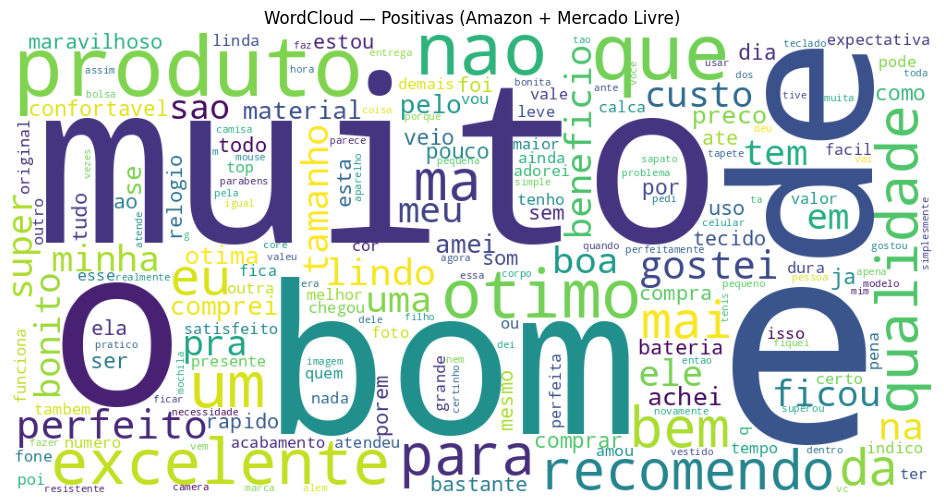

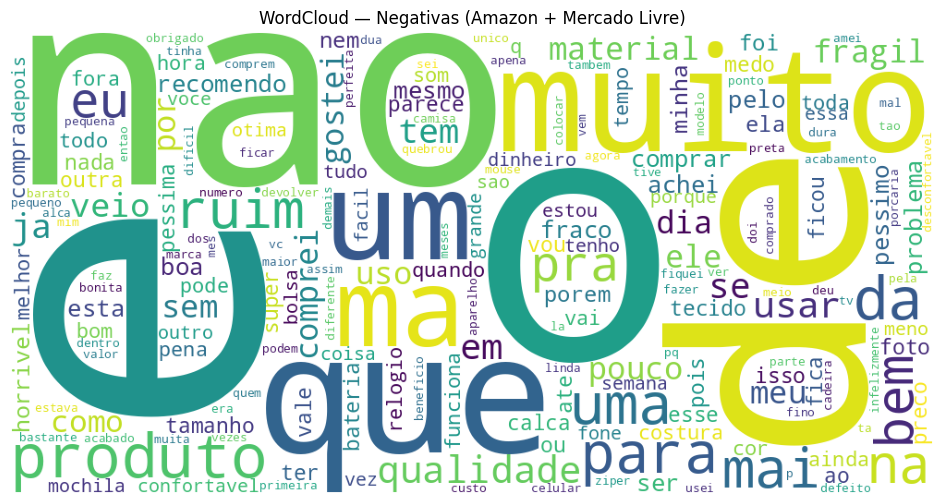

In [54]:
def plot_wordcloud(textos, titulo):
    texto_unido = " ".join(textos)
    nuvem = WordCloud(
        width=1000,
        height=500,
        background_color="white",
        collocations=False
    ).generate(texto_unido)

    plt.figure(figsize=(12, 6))
    plt.imshow(nuvem)
    plt.axis("off")
    plt.title(titulo)
    plt.show()

pos_textos = df_bin[df_bin["sentimento"] == "positivo"]["texto_limpo"]
neg_textos = df_bin[df_bin["sentimento"] == "negativo"]["texto_limpo"]

plot_wordcloud(pos_textos, "WordCloud — Positivas (Amazon + Mercado Livre)")
plot_wordcloud(neg_textos, "WordCloud — Negativas (Amazon + Mercado Livre)")


##Prever sentimento de texto novo

In [55]:
def prever_sentimento(texto):
    t = limpar_texto(texto)
    Xn = tfidf.transform([t])
    return modelo.predict(Xn)[0]

print("=== TESTE COM TEXTO NOVO ===")
ex1 = "Chegou rápido, excelente qualidade, recomendo!"
ex2 = "Horrível, veio com defeito e não funciona."
print(ex1, "->", prever_sentimento(ex1))
print(ex2, "->", prever_sentimento(ex2))


=== TESTE COM TEXTO NOVO ===
Chegou rápido, excelente qualidade, recomendo! -> positivo
Horrível, veio com defeito e não funciona. -> negativo


##Salvar modelo

In [57]:
joblib.dump(modelo, "modelo_sentimento.pkl")
joblib.dump(tfidf, "tfidf_sentimento.pkl")

print("Arquivos salvos:")
print("modelo_sentimento.pkl")
print("tfidf_sentimento.pkl")


Arquivos salvos:
modelo_sentimento.pkl
tfidf_sentimento.pkl


##% negativo por plataforma

In [58]:
total_por_plataforma = df.groupby("plataforma").size().rename("total")
neg_por_plataforma = df[df["sentimento"] == "negativo"].groupby("plataforma").size().rename("negativos")

res_plataforma = pd.concat([total_por_plataforma, neg_por_plataforma], axis=1).fillna(0)
res_plataforma["negativos"] = res_plataforma["negativos"].astype(int)
res_plataforma["pct_negativo"] = (res_plataforma["negativos"] / res_plataforma["total"]) * 100
res_plataforma = res_plataforma.sort_values("pct_negativo", ascending=False)

print("=== % NEGATIVO POR PLATAFORMA ===")
display(res_plataforma)


=== % NEGATIVO POR PLATAFORMA ===


,total,negativos,pct_negativo
plataforma,,,
Mercado Livre,59934,5213,8.697901
Amazon,9815,820,8.354559


##% negativo por plataforma

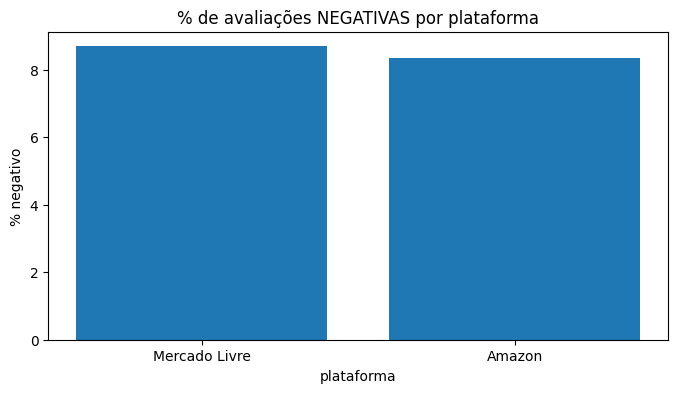

In [59]:
plt.figure(figsize=(8,4))
plt.bar(res_plataforma.index, res_plataforma["pct_negativo"])
plt.title("% de avaliações NEGATIVAS por plataforma")
plt.ylabel("% negativo")
plt.xlabel("plataforma")
plt.show()


##Top produtos com mais negativos

In [60]:
df_neg = df[df["sentimento"] == "negativo"].copy()

top_prod_neg = (
    df_neg.groupby(["plataforma", "produto"])
    .size()
    .reset_index(name="qtd_negativos")
    .sort_values("qtd_negativos", ascending=False)
)

print("= TOP 20 PRODUTOS COM MAIS NEGATIVOS (plataforma + produto) =")
display(top_prod_neg.head(20))


= TOP 20 PRODUTOS COM MAIS NEGATIVOS (plataforma + produto) =


,plataforma,produto,qtd_negativos
820,Mercado Livre,Mochila Masculina Faculdade Impermeável Resist...,161
920,Mercado Livre,Relógio Smartwatch Android Ios Inteligente D20...,91
478,Mercado Livre,Aspirador De Po Vertical Portatil Bivolt Usb R...,72
821,Mercado Livre,Mochila Masculina Feminina Escolar Bolsa Imper...,62
485,Mercado Livre,Atacado Semi Joias Kit 40 Peças Para Revenda +...,57
710,Mercado Livre,Kit 3 Calça Jeans Masculina Slim Original El...,53
733,Mercado Livre,Kit 3 Pares Sapato Social Masculino Verniz Ca...,53
593,Mercado Livre,Camisetas Masculinas Basica Gola Redonda 5 Uni...,49
905,Mercado Livre,Relógio Digital Esporte Bracelete Led Adulto I...,49
753,Mercado Livre,Kit Com 3 Camisa Gola Polo Marine Em Malha Piq...,48
